In [313]:
using Pkg

In [314]:
Pkg.activate("/Users/camillezaug/AMATH584")

 Activating environment at `~/AMATH584/Project.toml`


In [315]:
using Plots, LinearAlgebra, Images, LaTeXStrings, Netpbm, FileIO, ImageIO, ImageMagick, Statistics, StatsBase, Colors

# SVD on Yale Faces B

In this section, we will perform singular value decomposition on cropped images of faces (and later compare the results to uncropped faces). 

We will break the data up into training and testing data, where the testing data is about 30% of the original data. Images of each individual are reserved as test data at random.

In [316]:
path = "/Users/camillezaug/Desktop/AMATH 584/CroppedYale";

In [317]:
croppedYale = readdir(path);

In [318]:
# Extract the image date
# Create an array of arrays. Each entry will be a matrix corresponding to a single person.
# Each column of these matrices will correspond to an image
arrayArray = []
for faceDir in croppedYale
    singleFaceArray = []
    if !startswith(faceDir, ".")
        faces = readdir(string(path,"/",faceDir)) # All of the face .pgm images
        for face in faces
            if !startswith(face, ".")
                image = FileIO.load(string(path,"/",faceDir,"/",face))

                reshapedImage = reshape(Float64.(image),192*168)
                push!(singleFaceArray, reshapedImage)

            end
        end 
        push!(arrayArray, singleFaceArray)
    end
end

In [319]:
# Create training and testing data 
# This will be a matrix where each column corresponds to an image
# 30% of the images have been reserved as testing data

testFaces = []
trainFaces = []

for faceArray in arrayArray
    numFaces = length(faceArray)
    numTrain = Int(floor(0.7*numFaces))
    trainIndices = sample(1:numFaces, numTrain, replace = false) # Get 70% of each face's data
    trainFaces = vcat(trainFaces, faceArray[trainIndices]) # Combine each of the train sets for each face
        
    testIndices = setdiff(1:numFaces, trainIndices) # Get 30% test data
    testFaces = vcat(testFaces, faceArray[testIndices])
    
end


In [320]:
testFaces = hcat(testFaces...);
trainFaces = hcat(trainFaces...);

(32256, 1)


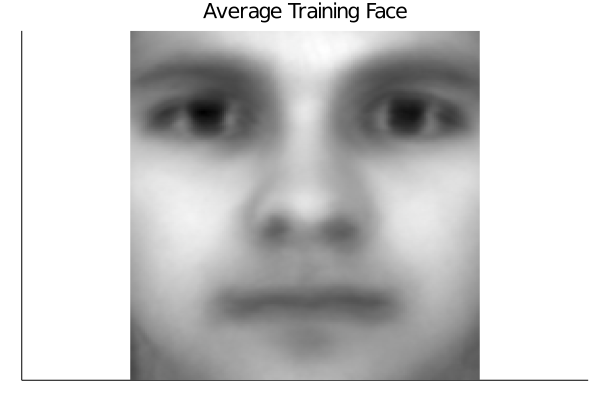

In [321]:
# Calculate the average face of the training data

avgFaceTrain = mean(trainFaces,dims = 2)
println(size(avgFaceTrain))
avgFace1 = reshape(avgFaceTrain[:,1], 192,168)
heatmap(rot180(avgFace1), color = :greys, legend = :none, axis = nothing, aspect_ratio = 168/192, title = "Average Training Face")

In [322]:
# Subtract out the average face from the training matrix
meanSubImageArrayTrain = trainFaces .- avgFaceTrain;

## 1. Perform SVD of the Training Images

In [323]:
svdImages = svd(meanSubImageArrayTrain);

## 2. Interpret SVD Results

### Interpret $\mathbf{U}$

$\mathbf{U}$ are the eigenfaces. The first column contains the eigenface that would produce the most accurate recreation of a face if a face were only projected onto that eigenface. The second column would produce the second most accurate recreation, etc. By projecting onto multiple eigenfaces at once, a more accurate recreation can be achieved than by projecting onto a single eigenface alone.

The first four eigenfaces are plotted below. 

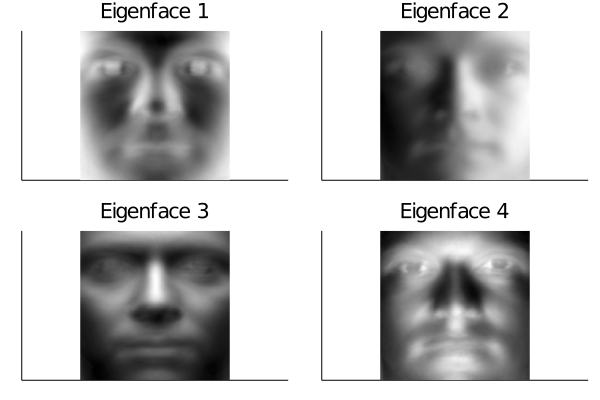

In [324]:
u = svdImages.U

uplots = []
for i in 1:4
    
    up = reshape(u[:,i], 192,168)
    
    push!(uplots,heatmap(rot180(up), color = :greys, legend = :none, axis = nothing, aspect_ratio = 168/192, title = string("Eigenface ",i)))
end


plot(uplots...)

### Interpret  $\mathbf{\Sigma}$

The matrix $\mathbf{\Sigma}$ contains all the singular values of the system. They are ordered from largest to smallest, with the largest corresponding to the first eigenface discussed previously. The larger a singular value, the more significant its eigenface to image reconstruction.

Singular values are discussed more in the next section.

### Interpret $\mathbf{V}$

The matrix is an orthonormal square matrix with $\mathbf{V}$ the dimensions of the number of test images. These vectors give the projection directions that take an image from its original basis to the eigenfaces basis.

## 2. Analyze Spectrum and Reconstruct Faces

### Singular value spectrum

The spectrum of the singular values is plotted below. The modes decay rapidly. The third plot is a log-plot of the first 100 modes, and its nonlinear, decreasing behaviour indicates that the modes decrease faster than exponentially. The second plot shows that the value of the modes appears to level off around 100 modes, indicating that this order of magnitude of modes may be sufficient for good image reconstruction.

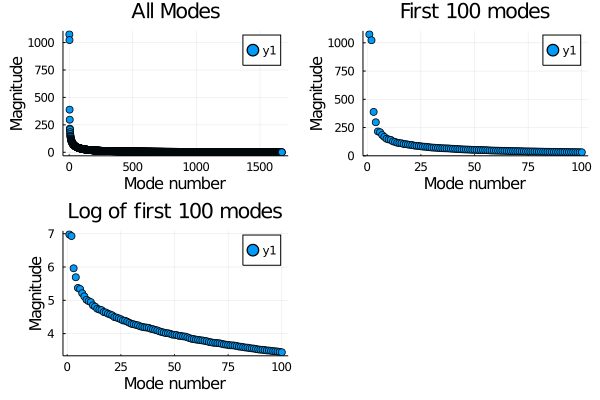

In [325]:
p1 = plot(svdImages.S,seriestype = :scatter, title = "All Modes")
p2 = plot(svdImages.S[1:100],seriestype = :scatter, title = "First 100 modes")
p3 = plot(log.(svdImages.S[1:100]),seriestype = :scatter, title = "Log of first 100 modes")

plot(p1,p2,p3, xlabel = "Mode number", ylabel = "Magnitude")

### Reconstruct test faces

We will reconstruct the test faces using the projection

$$
\tilde{\mathbf{x}}_{\text{test}} = \tilde{\mathbf{U}}\tilde{\mathbf{U}}^*\mathbf{x}_{\text{test}}
$$

using different ranks of the face space.

We will also assess the error between each reconstruction and the original image. 

Below, three images are chosen from the test set to perform detailed analysis on. The original image is plotted, as well as reconstruction with different values of the rank of the face space. Across all images, the reconstuction appears to improve as the rank increases. About 100-250 modes appear necessary for a decent approximation, and around 500 modes yields a reconstruction very similar to the original image.

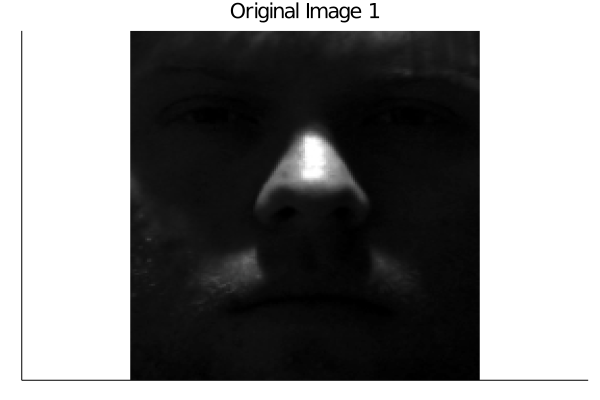

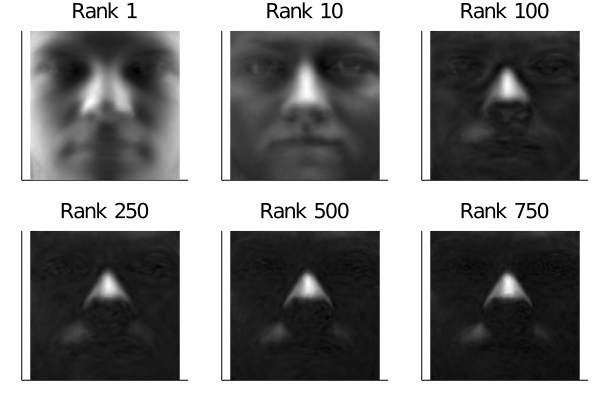

In [326]:
# Test Image 1

testImage1 = testFaces[:,1]

# Plot the test image
image1 = reshape(testImage1, 192,168)
display(heatmap(rot180(image1), color = :greys, legend = :none, axis = nothing, aspect_ratio = 168/192, title = string("Original Image 1")))

ranks = [1, 10, 100, 250, 500, 750]

p = Any[]
errors1 = []
for rank in ranks
    # Project
    reconstructImage = vcat(avgFaceTrain...) + u[:,1:rank]* ((u[:,1:rank]') * (testImage1-vcat(avgFaceTrain...)))
    image = reshape(reconstructImage, 192,168)
    push!(p,heatmap(rot180(image), color = :greys, legend = :none, axis = nothing, aspect_ratio = 168/192, title = string("Rank ",rank)))
    
    push!(errors1, norm((testImage1 - reconstructImage),2))
end

display(plot(p...))



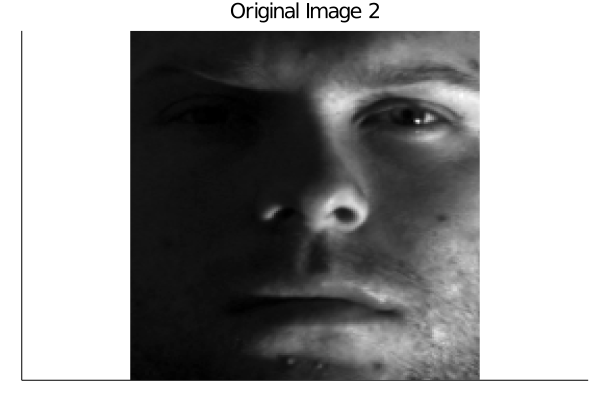

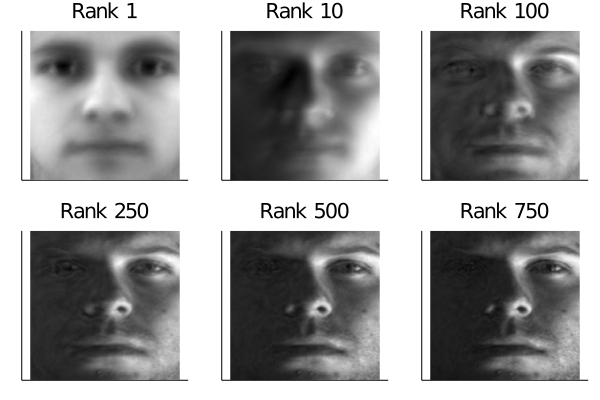

In [327]:
# Test Image 2

testImage2 = testFaces[:,10]

# Plot the test image
image2 = reshape(testImage2, 192,168)
display(heatmap(rot180(image2), color = :greys, legend = :none, axis = nothing, aspect_ratio = 168/192, title = string("Original Image 2")))

ranks = [1, 10, 100, 250, 500, 750]
errors2 = []
p = Any[]

for rank in ranks
    # Project
    reconstructImage = vcat(avgFaceTrain...) + u[:,1:rank]* ((u[:,1:rank]') * (testImage2-vcat(avgFaceTrain...)))
    image = reshape(reconstructImage, 192,168)
    push!(p,heatmap(rot180(image), color = :greys, legend = :none, axis = nothing, aspect_ratio = 168/192, title = string("Rank ",rank)))
    push!(errors2, norm((testImage2 - reconstructImage),2))
end



plot(p...)


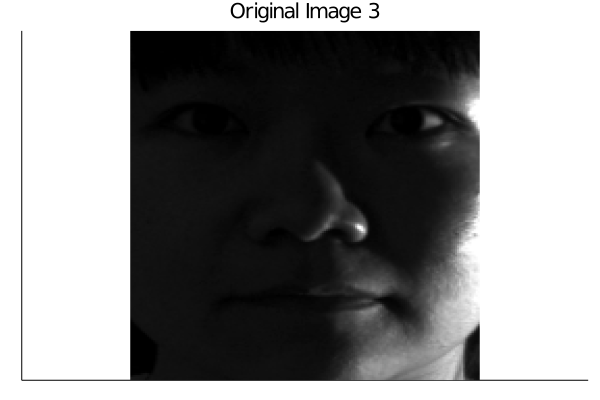

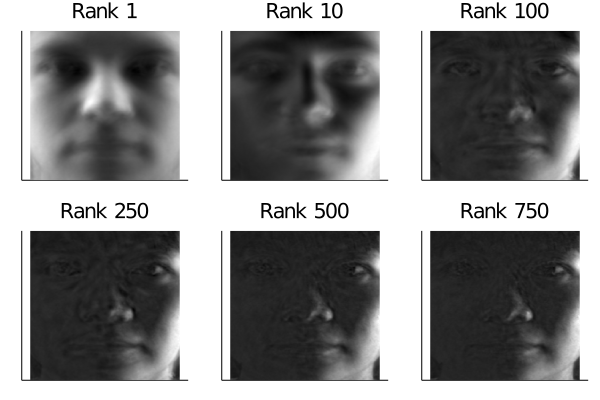

In [328]:
# Test Image 3

testImage3 = testFaces[:,90]

# Plot the test image
image3 = reshape(testImage3, 192,168)
display(heatmap(rot180(image3), color = :greys, legend = :none, axis = nothing, aspect_ratio = 168/192, title = string("Original Image 3")))

ranks = [1, 10, 100, 250, 500, 750]

p = Any[]
errors3 = []
for rank in ranks
    # Project
    reconstructImage = vcat(avgFaceTrain...) + u[:,1:rank]* ((u[:,1:rank]') * (testImage3-vcat(avgFaceTrain...)))
    image = reshape(reconstructImage, 192,168)
    push!(p,heatmap(rot180(image), color = :greys, legend = :none, axis = nothing, aspect_ratio = 168/192, title = string("Rank ",rank)))
    push!(errors3, norm((testImage3 - reconstructImage),2))
end



plot(p...)

Below we plot the errors produced by each rank for each image. We notice that with a rank of 1, the error varies wildly: the error for image 3 is nearly double that for image 2 (the difference in image quality is also clear when visually inspecting the recreations). However, as the rank increases, both the errors decrease and the variation across the errors decreases. 

When the rank is greater than 500, the error does not decrease much. Indeed, a visual analysis of all the images recreated with 500 modes confirms that this is a reasonable reconstruction.

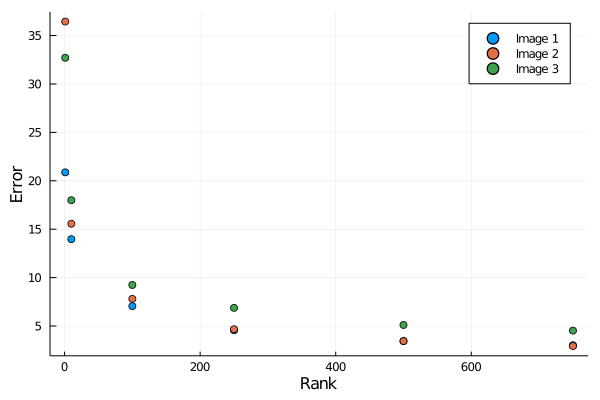

In [329]:
scatter(ranks,errors1, xlabel = "Rank",ylabel = "Error", label = "Image 1")
scatter!(ranks,errors2, label = "Image 2")
scatter!(ranks,errors3, label = "Image 3")

Finally, we will look at the average error produced across all test images with each rank in the plot below. The behavior is similar to that of test images 1, 2, and 3. The error is significantly larger at rank 1, 10, and 100 than at rank 500 and 750. It appears that increasing the rank beyond around 500 does not significantly improve the image reconstruction. This is a relatively small rank, as the singular value spectrum contains over 1500 modes!

In [330]:

numTest = size(testFaces)[2]
println(numTest)

for k in 1:numTest
    tFace = testFaces[:,k]

    # Plot the test image
    image = reshape(tFace, 192,168)
    
    ranks = [1, 10, 100, 250, 500, 750]
    errors = []
    
    for rank in ranks
        # Project
        reconstructImage = vcat(avgFaceTrain...) + u[:,1:rank]* ((u[:,1:rank]') * (tFace-vcat(avgFaceTrain...)))
        push!(errors, norm((tFace - reconstructImage),2))
    end
    
    push!(allErrors,errors)
end


760


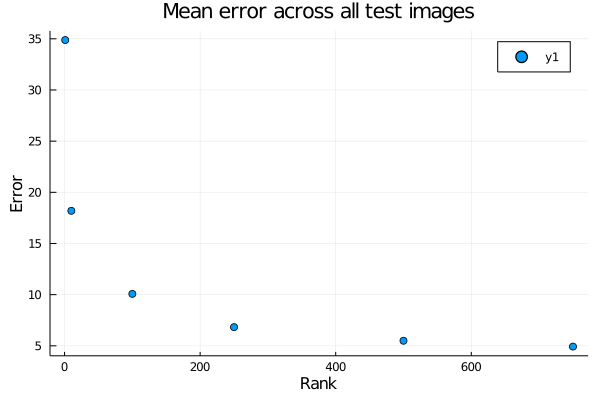

In [331]:
meanErrors = mean(hcat(allErrors...),dims = 2)
scatter(ranks,meanErrors, xlabel = "Rank",ylabel = "Error", title = "Mean error across all test images")

## 4. Comparison with Yale Faces B UNCROPPED

In this section, we will perform singular value decomposition on uncropped images of faces and compare it to the cropped results. 

As before, we break the data up into 70% train data and 30% test data. We perform the analysis on mean-subtracted test data, and we notice that the average face of this data set appear much less face-like than in the first data set. The variation between images is larger in this case, as the images are not restricted to just a subject's face: backgrounds, glasses, and other body parts are present.

In [332]:
path2 = "/Users/camillezaug/Desktop/AMATH 584/yalefaces_uncropped";

In [333]:
uncroppedYale = readdir(path2);

In [349]:
# Extract data
arrayArray = []
for ufaceDir in uncroppedYale
    singleFaceArray = []
    if !startswith(ufaceDir, ".")
        faces = readdir(string(path2,"/",ufaceDir)) # All of the face .pgm images
        for face in faces
            if !startswith(face, ".")
                image = FileIO.load(string(path2,"/",ufaceDir,"/",face))
                imgg = Gray.(image)
                reshapedImage = reshape(Float64.(imgg),243*320)
                push!(singleFaceArray, reshapedImage)

            end
        end 
        push!(arrayArray, singleFaceArray)
    end
end

In [359]:
# Create training and testing data 
# This will be a matrix where each column corresponds to an image
# 30% of the images have been reserved as testing data

utestFaces = []
utrainFaces = []

for faceArray in arrayArray
    numFaces = length(faceArray)
    numTrain = Int(floor(0.7*numFaces))
    trainIndices = sample(1:numFaces, numTrain, replace = false) # Get 70% of each face's data
    utrainFaces = vcat(utrainFaces, faceArray[trainIndices]) # Combine each of the train sets for each face
        
    testIndices = setdiff(1:numFaces, trainIndices) # Get 30% test data
    utestFaces = vcat(utestFaces, faceArray[testIndices])
    
end

In [363]:
utestFaces = hcat(utestFaces...);
utrainFaces = hcat(utrainFaces...);

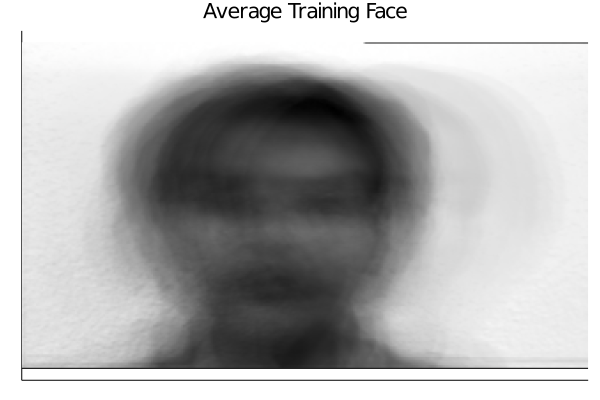

In [362]:
# Get the average face
# Calculate the average face of the training data

uavgFaceTrain = mean(utrainFaces,dims = 2)
uavgFace1 = reshape(uavgFaceTrain[:,1], 243,320)
heatmap(rot180(uavgFace1), color = :greys, legend = :none, axis = nothing, aspect_ratio = 243/320, title = "Average Training Face")

In [ ]:
# Subtract out the average face from the training matrix
umeanSubImageArrayTrain = utrainFaces .- uavgFaceTrain;

In [339]:
# Perform SVD

uSVDImages = svd(umeanSubImageArrayTrain);

### Analyze singular value spectrum

We notice that there are many fewer modes in this data set (as there are fewer images to analyze), and that the decay of the modes is less extreme. This indicates that a larger fraction of the total modes may be required for effective image recreation.

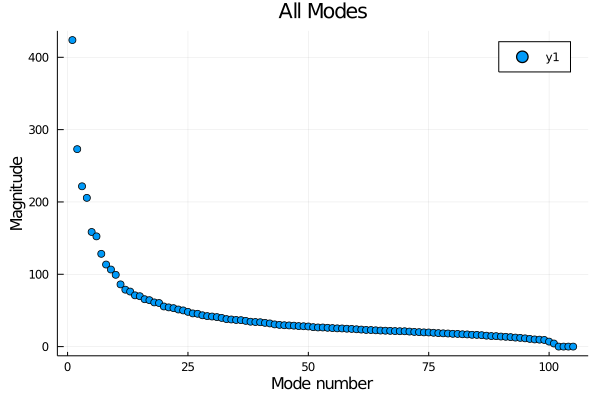

In [340]:
plot(uSVDImages.S,seriestype = :scatter,  xlabel = "Mode number", ylabel = "Magnitude", title = "All Modes")


### Reconstruct uncropped faces

To reconstruct the faces, we use the same method as for the uncropped faces: we take the SVD and project test images onto the face space.

We notice some differences in the reconstruction quality between the cropped and uncropped data. It takes a larger fraction of the singular values to get a decent reconstruction, and even then the image is not as clear as the original. Using rank 100 for the uncropped data appears to produce a worse reconstruction than in the uncropped case. 

In [341]:
u = uSVDImages.U;

In [342]:
# Test Image 1

utestImage1 = utestFaces[:,1]

# Plot the test image
uimage1 = reshape(utestImage1, 243,320)
display(heatmap(rot180(uimage1), color = :greys, legend = :none, axis = nothing, aspect_ratio = 243/320, title = string("Original Image 1")))

ranks = [1, 5, 10, 50, 75, 100]

p = Any[]
errors1 = []
for rank in ranks
    # Project
    reconstructImage = vcat(uavgFaceTrain...) + u[:,1:rank]* ((u[:,1:rank]') * (utestImage1-vcat(uavgFaceTrain...)))
    image = reshape(reconstructImage, 243,320)
    push!(p,heatmap(rot180(image), color = :greys, legend = :none, axis = nothing, aspect_ratio = 243/320, title = string("Rank ",rank)))
    
    push!(errors1, norm((utestImage1 - reconstructImage),2))
end

display(plot(p...))



LoadError: DimensionMismatch("new dimensions (243, 320) must be consistent with array size 0")

In [343]:
# Test Image 2

utestImage2 = utestFaces[:,10]

# Plot the test image
uimage2 = reshape(utestImage2, 243,320)
display(heatmap(rot180(uimage2), color = :greys, legend = :none, axis = nothing, aspect_ratio = 243/320, title = string("Original Image 2")))

ranks = [1, 5, 10, 50, 75, 100]

p = Any[]
errors2 = []
for rank in ranks
    # Project
    reconstructImage = vcat(uavgFaceTrain...) + u[:,1:rank]* ((u[:,1:rank]') * (utestImage2-vcat(uavgFaceTrain...)))
    image = reshape(reconstructImage, 243,320)
    push!(p,heatmap(rot180(image), color = :greys, legend = :none, axis = nothing, aspect_ratio = 243/320, title = string("Rank ",rank)))
    
    push!(errors2, norm((utestImage2 - reconstructImage),2))
end

display(plot(p...))

LoadError: BoundsError: attempt to access 0-element Array{Any,1} at index [1:0, 10]

In [344]:
# Test Image 3

utestImage3 = utestFaces[:,20]

# Plot the test image
uimage3 = reshape(utestImage3, 243,320)
display(heatmap(rot180(uimage3), color = :greys, legend = :none, axis = nothing, aspect_ratio = 243/320, title = string("Original Image 3")))

ranks = [1, 5, 10, 50, 75, 100]

p = Any[]
errors3 = []
for rank in ranks
    # Project
    reconstructImage = vcat(uavgFaceTrain...) + u[:,1:rank]* ((u[:,1:rank]') * (utestImage3-vcat(uavgFaceTrain...)))
    image = reshape(reconstructImage, 243,320)
    push!(p,heatmap(rot180(image), color = :greys, legend = :none, axis = nothing, aspect_ratio = 243/320, title = string("Rank ",rank)))
    
    push!(errors3, norm((utestImage3 - reconstructImage),2))
end

display(plot(p...))

LoadError: BoundsError: attempt to access 0-element Array{Any,1} at index [1:0, 20]

We can study the error produced by each reconstruction for our test images. We note that error decreases for all images as rank increase. Images 1 and 3 have similar errors at the latter ranks, though image 3 has a slightly higher error througout. However, we notice that image 3 has a significantly worse error than the other two. Investigating this difference, I noticed that image 2 is of a woman, and she is the only woman in the dataset. It seems training data was not adequately trained to reconstruct images of women, resulting in higher error. This highlights the necessity of unbiased training data if it is to be widely used.

Finally, we note that the errors for uncropped faces are all higher than errors for cropped faces. 

These results make sense, as the cropped data set is both smaller and has a wider variation between images, making reconstruction more difficult.

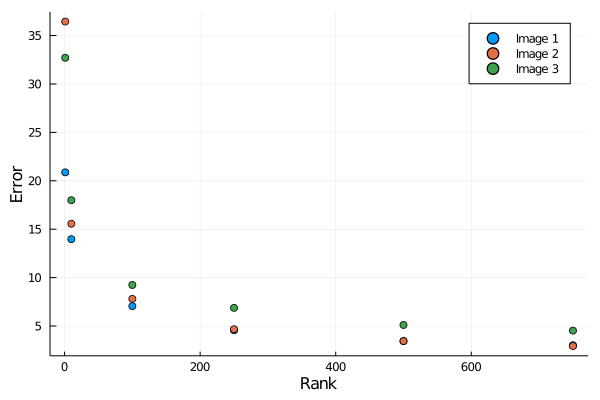

In [345]:
scatter(ranks,errors1, xlabel = "Rank", ylabel = "Error", label = "Image 1")
scatter!(ranks,errors2, label = "Image 2")
scatter!(ranks,errors3, label = "Image 3")

Computing the average errors across modes for the testing data, we note that the error for the uncropped data is on average much larger than the error for the cropped data at the same rank. To reduce the error significantly, a larger percent of modes are necessary (more than 75%).

Overall, these errors highlight the poorer reconstruction qualities of the uncropped data set. 

In [346]:
numTest = size(utestFaces)[2]

allErrors = [] 

for k in 1:numTest
    tFace = utestFaces[:,k]

    # Plot the test image
    image = reshape(tFace, 243,320)
    
    ranks = [1, 5, 10, 50, 75, 100]
    errors = []
    
    for rank in ranks
        # Project
        reconstructImage = vcat(uavgFaceTrain...) + u[:,1:rank]* ((u[:,1:rank]') * (tFace-vcat(uavgFaceTrain...)))
        push!(errors, norm((tFace - reconstructImage),2))
    end
    
    push!(allErrors,errors)
end

LoadError: BoundsError: attempt to access (0,)
  at index [2]

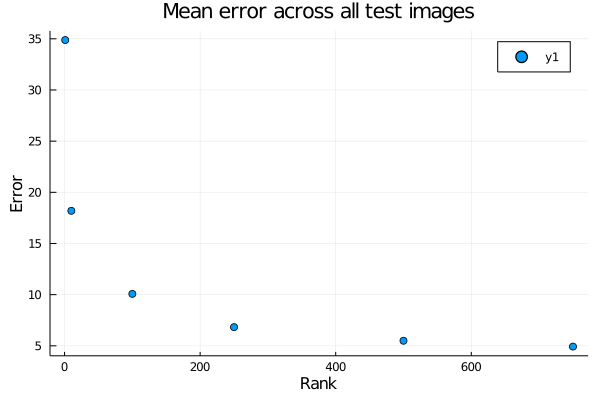

In [347]:
meanErrors = mean(hcat(allErrors...),dims = 2)
scatter(ranks,meanErrors, xlabel = "Rank",ylabel = "Error", title = "Mean error across all test images")